## 1. Making CSVs

In [ ]:
import pandas as pd

mon_test_path = '/content/mon_test_processed.csv'
mon_train_path = '/content/mon_train_processed.csv'
unmon_test_path = '/content/unmon_test_processed.csv'
unmon_train_path = '/content/unmon_train_processed.csv'

mon_test = pd.read_csv(mon_test_path)
mon_train = pd.read_csv(mon_train_path)
unmon_test = pd.read_csv(unmon_test_path)
unmon_train = pd.read_csv(unmon_train_path)

print('Loaded CSVs.')

Loaded CSVs.


In [ ]:
print(mon_test.columns)

Index(['trace_id', 'label', 'num_in', 'num_out', 'pkt_mean', 'pkt_std',
       't_min', 't_max', 't_mean', 't_med', 't_std', 't_q25', 't_q75',
       'cum_min', 'cum_max', 'cum_mean', 'cum_std', 'burst_min', 'burst_max',
       'burst_mean', 'burst_std', 'burst_cnt', 'ipt_min', 'ipt_max',
       'ipt_mean', 'ipt_med', 'ipt_std', 'ipt_q25', 'ipt_q75', 'total_packets',
       'incoming_ratio', 'outgoing_ratio', 'outgoing_avg', 'outgoing_std',
       'sum_cumulative', 'sum_bursts', 'packets_per_second',
       'incoming_first30', 'outgoing_first30'],
      dtype='object')


**Closed-world:**
the objective is to classify the 95 monitored websites.

**Open-world:**
we assume that users can visit any websites, including those we are not interested in. These are called "unmonitored" websites.

- Binary Classification: Determine whether the web traffic trace corresponds to a monitored website.

  To do this, reassign the label '1' to all monitored website instances (positive samples) and assign the label '-1' to all unmonitored website instances (negative samples). Train and test the model in this binary setting.

- Multi-Class Classification: Classify 95 monitored website traces with unique labels against additional unmonitored websites.

  In the multi-class setting, label the monitored website instances with {0, 1, 2, ..., 94} and the unmonitored website instances with the label '-1'.

---

outgoing_first30, incoming_first30, packets_per_second, cum_max 제외하고 (monitored 데이터셋은 trace_id도 drop)

In [ ]:
# 'outgoing_first30', 'incoming_first30', 'packets_per_second', 'cum_max' 제외
EXCLUDE_FEATURES = ['outgoing_first30', 'incoming_first30', 'packets_per_second', 'cum_max']

# 기존 label (웹사이트 당 10개 subpage) -> 0~94 웹사이트 종류 label로 변경
def to_site_label(df, label_col='label', urls_per_site=10):
    if label_col in df.columns:
        df = df.copy()
        df[label_col] = (df[label_col] // urls_per_site).astype(int)
    return df

mon_train = to_site_label(
    mon_train.drop(columns=EXCLUDE_FEATURES + ['trace_id'], errors='ignore'),
    'label',
    urls_per_site=10
)
mon_test = to_site_label(
    mon_test.drop(columns=EXCLUDE_FEATURES + ['trace_id'], errors='ignore'),
    'label',
    urls_per_site=10
)
unmon_train = unmon_train.drop(columns=EXCLUDE_FEATURES, errors='ignore')
unmon_test = unmon_test.drop(columns=EXCLUDE_FEATURES, errors='ignore')

# 1. Closed-world

closed_world_train = mon_train.copy()
closed_world_test = mon_test.copy()

# print(closed_world_train.columns)
closed_world_train.to_csv('/content/closed_world_train.csv', index=False)
closed_world_test.to_csv('/content/closed_world_test.csv', index=False)

print('Saved closed-world datasets.')


# 2. Open-world

# 2-1. Binary Classification:
#       mon_test, mon_train에 '1' label 부여, unmon_test, unmon_train에 '-1' label 부여하고
#       mon_test/unmon_test concat, mon_train/unmon_train concat
mon_train_bin = mon_train.copy()
mon_test_bin = mon_test.copy()
unmon_train_bin = unmon_train.copy()
unmon_test_bin = unmon_test.copy()

mon_train_bin['label'] = 1
mon_test_bin['label'] = 1
unmon_train_bin['label'] = -1
unmon_test_bin['label'] = -1

open_world_bin_train = pd.concat([mon_train_bin, unmon_train_bin], ignore_index=True)
open_world_bin_test = pd.concat([mon_test_bin, unmon_test_bin], ignore_index=True)

# print(open_world_bin_train.columns)
open_world_bin_train.to_csv('/content/open_world_bin_train.csv', index=False)
open_world_bin_test.to_csv('/content/open_world_bin_test.csv', index=False)

print('Saved open-world (binary) datasets.')


# 2-2. Multi-Class Classification
#       mon_test, mon_train은 'label' 그대로, unmon_test, unmon_train은 'label' column 추가하고 '-1' 부여
mon_train_mul = mon_train.copy()
mon_test_mul = mon_test.copy()
unmon_train_mul = unmon_train.copy()
unmon_test_mul = unmon_test.copy()

# unmonitored 데이터셋에 'label' 컬럼 새로 추가
unmon_train_mul['label'] = -1
unmon_test_mul['label'] = -1

open_world_mul_train = pd.concat([mon_train_mul, unmon_train_mul], ignore_index=True)
open_world_mul_test = pd.concat([mon_test_mul, unmon_test_mul], ignore_index=True)

# print(open_world_mul_train.columns)
open_world_mul_train.to_csv('/content/open_world_mul_train.csv', index=False)
open_world_mul_test.to_csv('/content/open_world_mul_test.csv', index=False)

print('Saved open-world (multi-class) datasets.')

print('All CSVs successfully created.')

Saved closed-world datasets.
Saved open-world (binary) datasets.
Saved open-world (multi-class) datasets.
All CSVs successfully created.


## 2. Closed World

### 2-1. Correlation 계산

correlation 기반 drop -> selected features only vs. all features 간단한 성능 비교

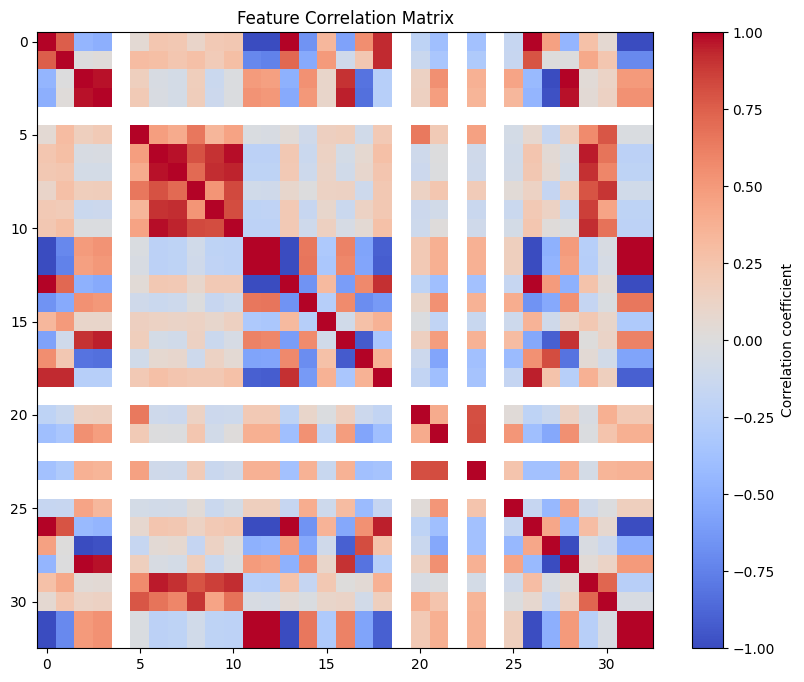

Highly correlated feature pairs (|r| > 0.9):
sum_cumulative  cum_min           0.999651
cum_min         sum_bursts        0.999651
                cum_std           0.999596
sum_cumulative  cum_std           0.999208
cum_std         sum_bursts        0.999208
num_in          cum_mean          0.999084
cum_std         cum_mean          0.998571
cum_mean        cum_min           0.998461
cum_min         num_in            0.998071
num_in          total_packets     0.998032
                cum_std           0.997859
cum_mean        sum_cumulative    0.997626
sum_bursts      cum_mean          0.997626
num_in          sum_cumulative    0.997400
                sum_bursts        0.997400
cum_mean        total_packets     0.996126
total_packets   cum_min           0.992475
                cum_std           0.992463
sum_cumulative  total_packets     0.990919
sum_bursts      total_packets     0.990919
t_q75           t_mean            0.977087
incoming_ratio  pkt_std           0.975863
pkt_std  

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

monitored_all = pd.concat([mon_train, mon_test])
corr = monitored_all.drop(columns=['label'], errors='ignore').corr()  # label 제외

# plot
plt.figure(figsize=(10,8))
plt.imshow(corr, cmap='coolwarm', interpolation='nearest')
plt.title("Feature Correlation Matrix")
plt.colorbar(label='Correlation coefficient')
plt.show()

# highly correlated 쌍 찾기
threshold = 0.9
corr_pairs = (
    corr.abs()
    .unstack()
    .sort_values(ascending=False)
    .drop_duplicates()
)
high_corr = corr_pairs[(corr_pairs < 1.0) & (corr_pairs > threshold)]

print("Highly correlated feature pairs (|r| > 0.9):")
print(high_corr)


In [ ]:
to_drop = set()
for f1, f2 in high_corr.index:
    if f1 not in to_drop:
        to_drop.add(f2)

print("Recommended features to drop due to high correlation:")
print(sorted(to_drop))
print(len(to_drop), '개')


Recommended features to drop due to high correlation:
['burst_cnt', 'burst_mean', 'burst_std', 'cum_mean', 'cum_min', 'cum_std', 'num_in', 'outgoing_avg', 'outgoing_ratio', 'pkt_mean', 'pkt_std', 'sum_bursts', 'sum_cumulative', 't_mean', 't_med', 'total_packets']
16 개


### 2-2. 모델 정확도 비교

Correlation 계산 결과

to_drop = [
    'burst_cnt', 'burst_mean', 'burst_std',
    'cum_mean', 'cum_min', 'cum_std',
    'num_in', 'outgoing_avg', 'outgoing_ratio',
    'pkt_mean', 'pkt_std',
    'sum_bursts', 'sum_cumulative',
    't_mean', 'total_packets'
]

이므로, drop하고 모델 정확도 비교

=> keep_features = [
    't_q25', 't_q75',
    'burst_min',
    'total_packets',
    'cum_max',
    'incoming_ratio',
    'ipt_mean', 'ipt_std', 'ipt_med'
]

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

# keep_features 정의 + 교집합 처리
keep_features = [
    't_q25', 't_q75',          # 시간 계열 중 하나
    'burst_min',               # burst 계열 중 하나
    'total_packets',           # 패킷 수 계열 중 하나
    'cum_max',
    'incoming_ratio',          # 비율 계열 중 하나
    'ipt_mean', 'ipt_std', 'ipt_med'  # inter-packet time 계열
]

# 현재 monitored_all 에서 실제 존재하는 피처만 사용
keep_features_in_use = [f for f in keep_features if f in monitored_all.columns]
missing = sorted(set(keep_features) - set(keep_features_in_use))
if missing:
    print("[Info] Missing features (auto-dropped):", missing)
print("[Info] keep_features used:", keep_features_in_use)


# 데이터 준비
#   A: Closed-world train/test, 전체 feature 사용한 버전
#   B: monitored_all에서 stratified sample로 A의 train 크기와 동일하게 (75%) 뽑고 keep_features만 사용
assert 'label' in closed_world_train.columns and 'label' in closed_world_test.columns, "label 컬럼 필요"

X_train_full = closed_world_train.drop(columns=['label'])
y_train_full = closed_world_train['label'].astype(int)

X_test_full  = closed_world_test.drop(columns=['label'])
y_test       = closed_world_test['label'].astype(int)  # 공통 target

# B: monitored_all에서 y 기준 계층 샘플링으로 len(A_train)개 추출
assert 'label' in monitored_all.columns, "monitored_all에 label이 필요"
y_all = monitored_all['label'].astype(int)

target_n = len(closed_world_train)
sss = StratifiedShuffleSplit(n_splits=1, train_size=target_n, random_state=42)
idx_train_keep, _ = next(sss.split(monitored_all, y_all))
sampled_keep = monitored_all.iloc[idx_train_keep].reset_index(drop=True)

# keep 모델용 train/test X 구성 (동일 테스트셋에서 동일 피처만 추출)
X_train_keep = sampled_keep[keep_features_in_use]
y_train_keep = sampled_keep['label'].astype(int)

X_test_keep = closed_world_test[keep_features_in_use]  # 같은 test에서 keep 피처만

print(f"[Shape] A (full) train: {X_train_full.shape}, test: {X_test_full.shape}")
print(f"[Shape] B (keep) train: {X_train_keep.shape}, test: {X_test_keep.shape}")
print(f"[Check] Train size matched? {len(X_train_full) == len(X_train_keep)}")


# XGBoost로 테스트
num_class = y_train_full.nunique()
common_params = dict(
    objective='multi:softmax',
    num_class=num_class,
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    tree_method='hist',
    random_state=42,
    eval_metric='mlogloss'
)

model_full = XGBClassifier(**common_params)
model_keep = XGBClassifier(**common_params)

# 학습
print("\n[Train] Model A (Full features) ...")
model_full.fit(X_train_full, y_train_full)

print("[Train] Model B (Keep features) ...")
model_keep.fit(X_train_keep, y_train_keep)

# 비교
y_pred_full = model_full.predict(X_test_full) # 전체 feature 사용
y_pred_keep = model_keep.predict(X_test_keep) # 일부 feature 사용

acc_full = accuracy_score(y_test, y_pred_full)
acc_keep = accuracy_score(y_test, y_pred_keep)

print("\n==== Accuracy Comparison (Closed-world, same test) ====")
print(f"A) Full features on closed_world_train  -> Acc: {acc_full:.4f}")
print(f"B) Keep features (stratified {target_n} from monitored_all) -> Acc: {acc_keep:.4f}")


[Info] Missing features (auto-dropped): ['cum_max']
[Info] keep_features used: ['t_q25', 't_q75', 'burst_min', 'total_packets', 'incoming_ratio', 'ipt_mean', 'ipt_std', 'ipt_med']
[Shape] A (full) train: (14250, 33), test: (4750, 33)
[Shape] B (keep) train: (14250, 8), test: (4750, 8)
[Check] Train size matched? True

[Train] Model A (Full features) ...
[Train] Model B (Keep features) ...

==== Accuracy Comparison (Closed-world, same test) ====
A) Full features on closed_world_train  -> Acc: 0.7535
B) Keep features (stratified 14250 from monitored_all) -> Acc: 0.9040


## 3. Open World - Multiclass

### 3-1. Feature Selection

KS-test, Mann-Whitney U test로 mon-unmon 간 다르게 분포하는 feature 탐색

In [ ]:
import pandas as pd
from scipy.stats import mannwhitneyu, ks_2samp

# 1. 데이터 분리
mon = open_world_mul_train[open_world_mul_train['label'] != -1].drop(columns=['label'])
unmon = open_world_mul_train[open_world_mul_train['label'] == -1].drop(columns=['label'])

print(f"Monitored samples: {len(mon)}, Unmonitored samples: {len(unmon)}")

# Feature 분포 비교
results = []
for col in mon.columns:
    # 결측값 제거
    x = mon[col].dropna()
    y = unmon[col].dropna()
    if x.nunique() < 5 or y.nunique() < 5:
        continue  # 값이 너무 단조로우면 스킵

    # 두 가지 검정 병행
    ks_stat, ks_p = ks_2samp(x, y)
    mw_stat, mw_p = mannwhitneyu(x, y, alternative='two-sided')

    results.append({
        'feature': col,
        'ks_stat': ks_stat,
        'ks_p': ks_p,
        'mw_stat': mw_stat,
        'mw_p': mw_p
    })

df_diff = pd.DataFrame(results)

# 유의하게 다른 feature 추출
n1, n2 = len(mon), len(unmon)
mw_upper = 0.95 * n1 * n2
mw_lower = 0.05 * n1 * n2

# KS + MW 극단
sig_features = df_diff[
    ((df_diff['ks_p'] < 0.05) | (df_diff['mw_p'] < 0.05)) &   # 유의성
    (df_diff['ks_stat'] > 0.3) &                              # 분포 차이 충분
    ((df_diff['mw_stat'] <= mw_lower) | (df_diff['mw_stat'] >= mw_upper))  # 순위 분리
].sort_values(by='ks_stat', ascending=False)

print(f"\nmon과 unmon에서 다르게 분포하는 feature: {len(sig_features)}개")
print(sig_features[['feature', 'ks_stat', 'ks_p', 'mw_stat', 'mw_p']])

Monitored samples: 14250, Unmonitored samples: 7500

mon과 unmon에서 다르게 분포하는 feature: 22개
           feature   ks_stat  ks_p      mw_stat  mw_p
0           num_in  1.000000   0.0          0.0   0.0
1          num_out  1.000000   0.0          0.0   0.0
3          pkt_std  1.000000   0.0          0.0   0.0
4            t_max  1.000000   0.0          0.0   0.0
13       burst_min  1.000000   0.0  106875000.0   0.0
10         cum_min  1.000000   0.0  106875000.0   0.0
28      sum_bursts  1.000000   0.0  106875000.0   0.0
27  sum_cumulative  1.000000   0.0  106875000.0   0.0
12         cum_std  1.000000   0.0          0.0   0.0
11        cum_mean  1.000000   0.0  106875000.0   0.0
14       burst_max  1.000000   0.0          0.0   0.0
17       burst_cnt  1.000000   0.0          0.0   0.0
16       burst_std  1.000000   0.0          0.0   0.0
15      burst_mean  1.000000   0.0  106875000.0   0.0
22   total_packets  1.000000   0.0          0.0   0.0
2         pkt_mean  0.999867   0.0  106873978.0 

In [ ]:
# Closed-world에서 monitored 내 클래스 분류 feature

keep_features = [
    't_q25', 't_q75',          # 시간 계열 중 하나
    'burst_min',               # burst 계열 중 하나
    'total_packets',           # 패킷 수 계열 중 하나
    'cum_max',
    'incoming_ratio',          # 비율 계열 중 하나
    'ipt_mean', 'ipt_std', 'ipt_med'  # inter-packet time 계열
]

print('Cloased World Features')
print(keep_features)

top_5 = sig_features['feature'].head(5).tolist()
top_10 = sig_features['feature'].head(10).tolist()
top_15 = sig_features['feature'].head(15).tolist()
top_20 = sig_features['feature'].head(20).tolist()

print('\nOpen World (Multiclass) Features')
print(f'top 5 features: {top_5}')
print(f'top 10 features: {top_10}')
print(f'top 15 features: {top_15}')
print(f'top 20 features: {top_20}')

Cloased World Features
['t_q25', 't_q75', 'burst_min', 'total_packets', 'cum_max', 'incoming_ratio', 'ipt_mean', 'ipt_std', 'ipt_med']

Open World (Multiclass) Features
top 5 features: ['num_in', 'num_out', 'pkt_std', 't_max', 'burst_min']
top 10 features: ['num_in', 'num_out', 'pkt_std', 't_max', 'burst_min', 'cum_min', 'sum_bursts', 'sum_cumulative', 'cum_std', 'cum_mean']
top 15 features: ['num_in', 'num_out', 'pkt_std', 't_max', 'burst_min', 'cum_min', 'sum_bursts', 'sum_cumulative', 'cum_std', 'cum_mean', 'burst_max', 'burst_cnt', 'burst_std', 'burst_mean', 'total_packets']
top 20 features: ['num_in', 'num_out', 'pkt_std', 't_max', 'burst_min', 'cum_min', 'sum_bursts', 'sum_cumulative', 'cum_std', 'cum_mean', 'burst_max', 'burst_cnt', 'burst_std', 'burst_mean', 'total_packets', 'pkt_mean', 'outgoing_avg', 't_q75', 't_med', 't_mean']


### 3-2. 모델 정확도 비교 - 데이터 & 함수 setting

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier

assert 'label' in open_world_mul_train.columns and 'label' in open_world_mul_test.columns, "label 컬럼 필요"

X_train_all = open_world_mul_train.drop(columns=['label'])
y_train_all = open_world_mul_train['label'].astype(int)
X_test_all  = open_world_mul_test.drop(columns=['label'])
y_test_all  = open_world_mul_test['label'].astype(int)

# label 인코딩 (-1,0..94 -> 0..95)
le = LabelEncoder()
le.fit(pd.concat([y_train_all, y_test_all], axis=0))
y_train_enc = le.transform(y_train_all)
y_test_enc  = le.transform(y_test_all)
num_class = len(le.classes_)

print(f"[Train] {X_train_all.shape}, [Test] {X_test_all.shape}, Classes={num_class}")

In [ ]:
def filter_existing(feat_list, df):
    used = [f for f in feat_list if f in df.columns]
    missing = sorted(set(feat_list) - set(used))
    if missing:
        print(f"[Info] Missing features (auto-dropped): {missing}")
    print(f"[Info] Using {len(used)} features: {used}")
    return used



# 공통 param
common_params = dict(
    objective='multi:softmax',
    num_class=num_class,
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    tree_method='hist',
    random_state=42,
    eval_metric='mlogloss'
)

def train_eval(X_tr, y_tr, X_te, y_te, desc):
    print(f"\n[Train] {desc} ...  (dim={X_tr.shape[1]})")
    model = XGBClassifier(**common_params)
    model.fit(X_tr, y_tr)
    pred = model.predict(X_te)
    acc = accuracy_score(y_te, pred)
    f1m = f1_score(y_te, pred, average='macro')
    print(f"==== {desc} ====")
    print(f"Acc: {acc:.4f}")
    print(f"Macro-F1: {f1m:.4f}")
    return acc, f1m


results = {}  # 비교용

[Train] (21750, 33), [Test] (7250, 33), Classes=96
[Info] Missing features (auto-dropped): ['cum_max']
[Info] Using 16 features: ['t_q25', 't_q75', 'burst_min', 'total_packets', 'incoming_ratio', 'ipt_mean', 'ipt_std', 'ipt_med', 'num_in', 'num_out', 'pkt_std', 't_max', 'cum_min', 'sum_bursts', 'cum_std', 'burst_cnt']
[Info] Using 17 features: ['num_in', 'num_out', 'pkt_std', 't_max', 'burst_min', 'cum_min', 'sum_bursts', 'sum_cumulative', 'cum_std', 'cum_mean', 'burst_max', 'burst_cnt', 'burst_std', 'burst_mean', 'total_packets', 'incoming_ratio', 'ipt_mean']
[Info] Using 11 features: ['num_in', 'num_out', 'pkt_std', 't_max', 'burst_min', 'burst_cnt', 'incoming_ratio', 'ipt_std', 't_q75', 'total_packets', 'cum_std']

[Train] All features ...  (dim=33)
==== All features ====
Acc: 0.8349
Macro-F1: 0.7494

[Train] Feature set A ...  (dim=16)
==== Feature set A ====
Acc: 0.8026
Macro-F1: 0.7012

[Train] Feature set B ...  (dim=17)
==== Feature set B ====
Acc: 0.8112
Macro-F1: 0.7127

[Tra

### 3-3. Feature별 모델 정확도

In [ ]:
# A

features_A = [
    # Closed-world features
    't_q25', 't_q75', 'burst_min', 'total_packets', 'cum_max',
    'incoming_ratio', 'ipt_mean', 'ipt_std', 'ipt_med',

    # Open-world features
    'num_in', 'num_out', 'pkt_std', 't_max', 'cum_min',
    'sum_bursts', 'cum_std', 'burst_cnt'
]

features_A = filter_existing(features_A, X_train_all)
results['A'] = train_eval(X_train_all[features_A], y_train_enc,
                          X_test_all[features_A], y_test_enc, "Feature set A")

In [ ]:
# B

features_B = [
    # Open-world top15 features
    'num_in', 'num_out', 'pkt_std', 't_max', 'burst_min',
    'cum_min', 'sum_bursts', 'sum_cumulative', 'cum_std', 'cum_mean',
    'burst_max', 'burst_cnt', 'burst_std', 'burst_mean', 'total_packets',

    # Closed-world 중 open world feature와 겹치지 않는 계열
    'incoming_ratio', 'ipt_mean'
]

features_B = filter_existing(features_B, X_train_all)
results['B'] = train_eval(X_train_all[features_B], y_train_enc,
                          X_test_all[features_B], y_test_enc, "Feature set B")

In [ ]:
# C: 경량 (11개 feature)
features_C = [
    'num_in', 'num_out', 'pkt_std', 't_max', 'burst_min', 'burst_cnt',
    'incoming_ratio', 'ipt_std', 't_q75', 'total_packets', 'cum_std'
]

features_C = filter_existing(features_C, X_train_all)
results['C'] = train_eval(X_train_all[features_C], y_train_enc,
                          X_test_all[features_C], y_test_enc, "Feature set C")

In [ ]:
# D: closed world용 feature + open world용 15개 concat
features_D = list(set(keep_features + top_15))

features_D = filter_existing(features_D, X_train_all)
results['D'] = train_eval(X_train_all[features_D], y_train_enc,
                          X_test_all[features_D], y_test_enc, "Feature set D")

[Info] Missing features (auto-dropped): ['cum_max']
[Info] Using 21 features: ['burst_min', 't_q75', 'cum_mean', 'pkt_std', 'num_out', 'ipt_mean', 'cum_min', 't_q25', 'sum_bursts', 'burst_mean', 'cum_std', 'incoming_ratio', 'total_packets', 'num_in', 'burst_max', 't_max', 'sum_cumulative', 'burst_std', 'ipt_med', 'burst_cnt', 'ipt_std']

[Train] Feature set D ...  (dim=21)
==== Feature set D ====
Acc: 0.8234
Macro-F1: 0.7322


In [ ]:
# 테스트

features_E = list(set(keep_features + sig_features['feature'].tolist()))

features_E = filter_existing(features_E, X_train_all)
results['E'] = train_eval(X_train_all[features_E], y_train_enc,
                          X_test_all[features_E], y_test_enc, "Feature set E")

[Info] Missing features (auto-dropped): ['cum_max']
[Info] Using 25 features: ['burst_min', 't_q75', 't_med', 'pkt_mean', 'cum_mean', 'pkt_std', 'num_out', 'ipt_mean', 'cum_min', 't_q25', 't_mean', 'sum_bursts', 'burst_mean', 'cum_std', 'incoming_ratio', 'total_packets', 'num_in', 'burst_max', 'outgoing_avg', 't_max', 'sum_cumulative', 'burst_std', 'ipt_med', 'burst_cnt', 'ipt_std']

[Train] Feature set E ...  (dim=25)
==== Feature set E ====
Acc: 0.8230
Macro-F1: 0.7316


### 3-4. 결과 요약

In [ ]:
df_results = pd.DataFrame(results, index=['Accuracy','Macro-F1']).T
print("\n==== Accuracy Comparison (Open world multiclass) ====")
print(df_results)


==== Accuracy Comparison (Open world multiclass) ====
     Accuracy  Macro-F1
All  0.834897  0.749389
A    0.802621  0.701155
B    0.811172  0.712711
C    0.803034  0.701235
D    0.823448  0.732178
